# MNIST Classification with 2-Layer NNs
### UCR EE/CS 228 Introduction to Deep Learning, Instructor: Yinglun Zhu (yinglunz.com)

Part of the code is borrowed from the PyTorch Tutorial https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [3]:
# Download training data from open datasets.
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [5]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(train_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [7]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device.")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device.
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
)


Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])


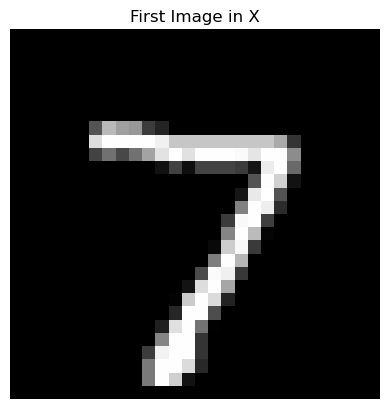

Label of the image is 7.


In [11]:
# Example data points
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    idx = 0
    image, label = X[idx], y[idx]
    # If the image is a grayscale image, squeeze the channel dimension
    if image.shape[0] == 1:
        image = image.squeeze(0)  # remove the channel dimension [1, H, W] -> [H, W]

    # If the image is a tensor, convert it to a NumPy array
    image = image.cpu().numpy()

    # Display the image using matplotlib
    plt.imshow(image, cmap='gray')  # If it's a grayscale image, you can use cmap='gray'
    plt.title("First Image in X")
    plt.axis('off')  # Hide the axes
    plt.show()
    
    print(f"Label of the image is {label}.")  
    break

In [13]:
# View size of inputs/outputs
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    flatten = nn.Flatten()
    print(f"Shape of nn.Flatten(X) [N, C, H, W]: {(flatten(X).shape)}")
    print(f"Shape of output logits: {model(X).shape}")
    print(f"Example output logits: {model(X)[0]}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of nn.Flatten(X) [N, C, H, W]: torch.Size([64, 784])
Shape of output logits: torch.Size([64, 10])
Example output logits: tensor([-0.1065,  0.0253, -0.1043,  0.0703, -0.0083,  0.0638,  0.0233, -0.0308,
        -0.0367, -0.0257], grad_fn=<SelectBackward0>)


In [15]:
# Specify loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [21]:
# Training function
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 200 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [23]:
# Test function
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [27]:
# Test randomly initialized NN
torch.manual_seed(40)
model = NeuralNetwork().to(device)
test(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 6.0%, Avg loss: 2.313825 



In [31]:
# Test trained NN
torch.manual_seed(42)
model = NeuralNetwork().to(device)
# Specify loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.321668  [   64/60000]
loss: 2.278293  [12864/60000]
loss: 2.213543  [25664/60000]
loss: 2.169127  [38464/60000]
loss: 2.097264  [51264/60000]
Test Error: 
 Accuracy: 67.0%, Avg loss: 2.078303 

Epoch 2
-------------------------------
loss: 2.088561  [   64/60000]
loss: 2.073174  [12864/60000]
loss: 1.963305  [25664/60000]
loss: 1.886706  [38464/60000]
loss: 1.808463  [51264/60000]
Test Error: 
 Accuracy: 74.5%, Avg loss: 1.780720 

Epoch 3
-------------------------------
loss: 1.798216  [   64/60000]
loss: 1.789863  [12864/60000]
loss: 1.636804  [25664/60000]
loss: 1.545236  [38464/60000]
loss: 1.483163  [51264/60000]
Test Error: 
 Accuracy: 78.1%, Avg loss: 1.444054 

Epoch 4
-------------------------------
loss: 1.475984  [   64/60000]
loss: 1.466177  [12864/60000]
loss: 1.304492  [25664/60000]
loss: 1.224155  [38464/60000]
loss: 1.206294  [51264/60000]
Test Error: 
 Accuracy: 81.2%, Avg loss: 1.158204 

Epoch 5
------------------------